In [26]:
from datasets import load_dataset
# Full dataset
dataset = load_dataset("rafaelpadilla/coco2017")

train_dataset = dataset["train"]
val_dataset = dataset["val"]

In [27]:
labels = ["None", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe", "eye glasses", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "mirror", "dining table", "window", "desk", "toilet", "door", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush", "hair brush"]
print(len(labels))
print(train_dataset[3].keys())
print(train_dataset[3])
print([(id, labels[id]) for id in range(len(labels))])

print(train_dataset[3]['image'].size)

92
dict_keys(['image', 'image_id', 'objects'])
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x365 at 0x147C4031F550>, 'image_id': 63879, 'objects': {'id': [336129, 674780, 1142474, 1145089, 1158532], 'area': [4737.597749999999, 4254.8196499999995, 2210.926700000001, 4068.0025500000015, 2373.64885], 'bbox': [[467.8900146484375, 55.63999938964844, 101.25, 49.0], [364.6000061035156, 235.1199951171875, 64.02999877929688, 80.51000213623047], [225.7100067138672, 220.02999877929688, 57.5099983215332, 43.970001220703125], [34.369998931884766, 149.75999450683594, 55.650001525878906, 170.22999572753906], [110.55000305175781, 170.22999572753906, 60.459999084472656, 72.25]], 'label': [85, 47, 84, 84, 87], 'iscrowd': [False, False, False, False, False]}}
[(0, 'None'), (1, 'person'), (2, 'bicycle'), (3, 'car'), (4, 'motorcycle'), (5, 'airplane'), (6, 'bus'), (7, 'train'), (8, 'truck'), (9, 'boat'), (10, 'traffic light'), (11, 'fire hydrant'), (12, 'street sign'), (13, 'stop sig

In [28]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert

def show_image(img, bbox, label_ids):
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()
    tensor_image = to_tensor(img)
    if bbox is not None and label_ids is not None:
        bbox = box_convert(torch.Tensor(bbox), 'xywh', 'xyxy')
        tensor_image = draw_bounding_boxes(tensor_image, bbox, [labels[l] for l in label_ids], width=4)
    pil_image = to_pil(tensor_image)
    plt.imshow(pil_image)
    plt.title(str(img.size))
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

import random

def show_some_pics_with_bbox(dataset = train_dataset, num = 5):
    random_integers = [random.randint(0, len(train_dataset)) for _ in range(num)]
    for i in random_integers:
        show_image(train_dataset[i]["image"], train_dataset[i]["objects"]["bbox"], train_dataset[i]["objects"]["label"])

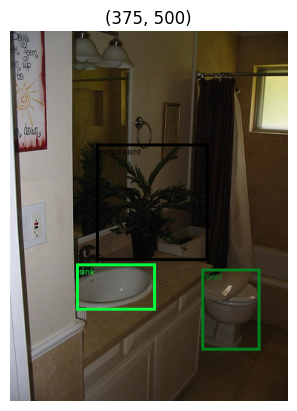

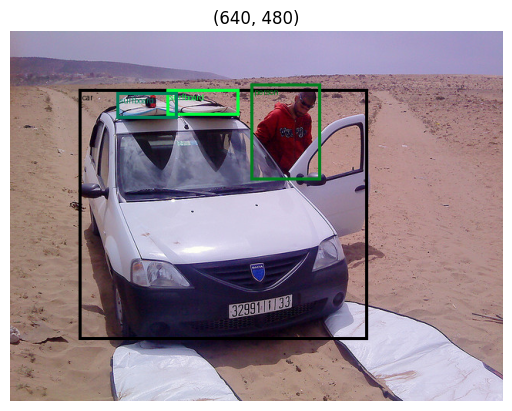

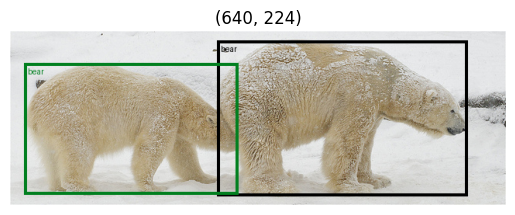

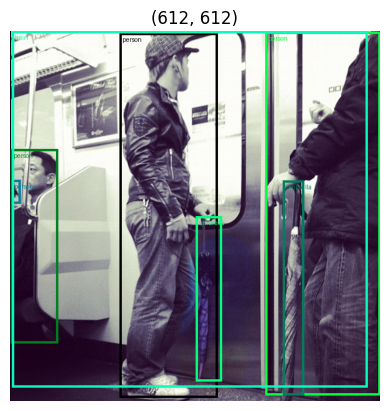

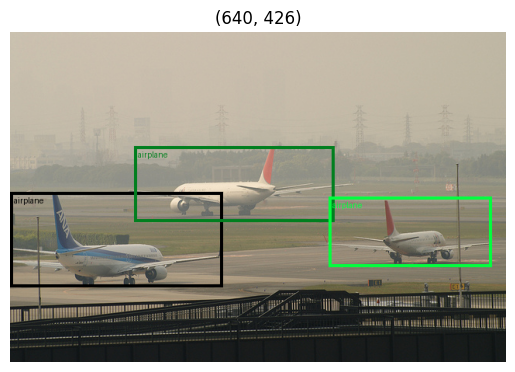

In [29]:

show_some_pics_with_bbox(train_dataset, 5)

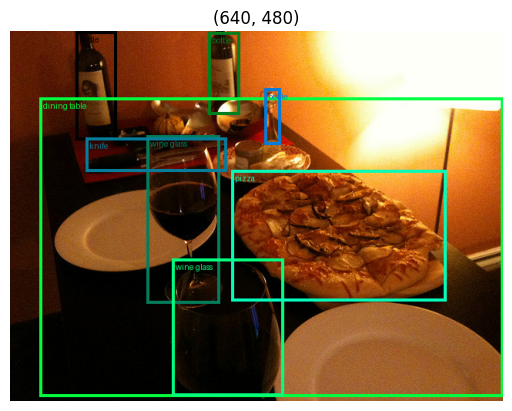

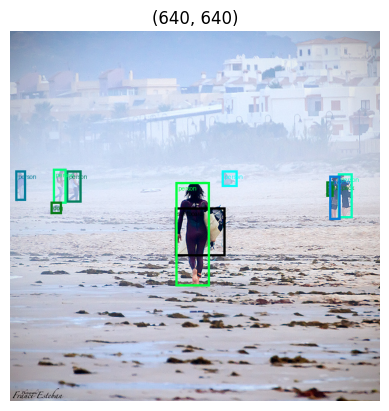

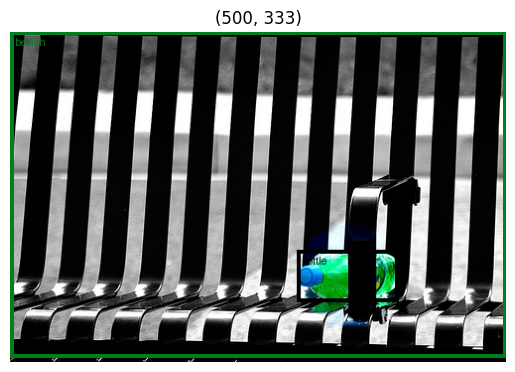

In [30]:
show_some_pics_with_bbox(val_dataset, 3)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x147C403371C0>


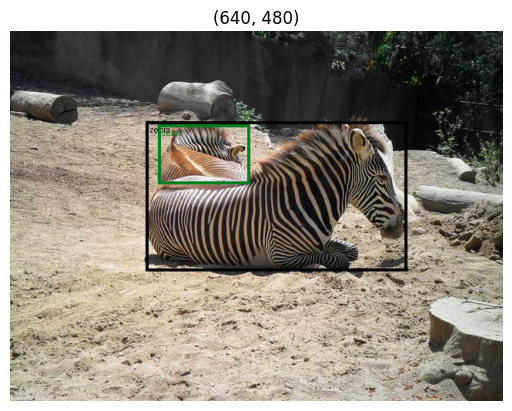

In [31]:
from PIL import Image
import requests
from io import BytesIO

# { "id": [ 271630 ], "area": [ 117302.03975 ], "bbox": [ [ 120, 23.239999771118164, 391.3500061035156, 397.8399963378906 ] ], "label": [ 13 ], "iscrowd": [ false ] }
# response = requests.get("")
# img = Image.open(BytesIO(response.content))
# img = Image.open("test_data/val_191471.jpg")
# print(img)
# bbox=[ [ 120, 23.239999771118164, 391.3500061035156, 397.8399963378906 ] ]
# label=[ 13 ]
# show_image(img, bbox, label)

# { "id": [ 590587, 591955 ], "area": [ 40861.27974999998, 6793.037800000001 ], "bbox": [ [ 176.61000061035156, 117.55999755859375, 339.1499938964844, 193.9499969482422 ], [ 192, 121.08000183105469, 119.7300033569336, 77.66000366210938 ] ], "label": [ 24, 24 ], "iscrowd": [ false, false ] }
img = Image.open("../train_data/train_160437.jpg")
print(img)
bbox=[ [ 176.61000061035156, 117.55999755859375, 339.1499938964844, 193.9499969482422 ], [ 192, 121.08000183105469, 119.7300033569336, 77.66000366210938 ] ]
label=[ 24, 24 ]

show_image(img, bbox, label)

In [32]:
import sys
from pathlib import Path
sys.path.append("../util")  # TODO: fix this ugly import hack

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"


from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from vision_util import process_vision_info
from util.coco_dataloader import convert_tokens_to_bbox_xyhw_and_label_id

model_dir = "../train_output/20241006115325/checkpoint-epoch-9-steps-27000-loc_size-100-grad_accu-2-640X480-only"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_dir, torch_dtype="auto", device_map="auto"
)


processor = AutoProcessor.from_pretrained(model_dir, min_pixels=256*28*28, max_pixels=256*28*28, padding_side="left")

messages1 = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": img,
            },
            {"type": "text", "text": "描述一下这个图片，把其中的物体名称和位置标注出来"},
        ],
    }
]

# https://huggingface.co/datasets/rafaelpadilla/coco2017/viewer/default/val?row=41 image_id: 191471 , image_size:(640, 480)
# { "id": [ 271630 ], "area": [ 117302.03975 ], 
# "bbox": [ [ 120, 23.239999771118164, 391.3500061035156, 397.8399963378906 ] ], 
# "label": [ 13 ], "iscrowd": [ false ] 
# }

messages = [messages1]
texts = [
    processor.apply_chat_template(msg, tokenize=False, add_generation_prompt=True)
    for msg in messages
]

image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=texts,
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
print(f"generated_ids: {generated_ids}")
print(f"generated tokens: {processor.tokenizer.decode(generated_ids[0])}")
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
print(f"generated_ids_trimmed: {generated_ids_trimmed}")
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(f"output_text: {output_text}")
bbox, label_ids = convert_tokens_to_bbox_xyhw_and_label_id(output_text[0], processor, (640, 480))
print(bbox, label_ids)


Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


generated_ids: tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         1516

In [33]:
print(processor.tokenizer.vocab_size)
print(processor.tokenizer.additional_special_tokens_ids)
print(processor.tokenizer.decode([151656]))
print(processor.tokenizer.decode([151657])) # return None
print(processor.tokenizer.decode([151640, 151641, 151642, 151643, 151644, 151645, 151646, 151647, 151648, 151649, 151650, 151651, 151652, 151653, 151654, 151655, 151656]))
print(processor.tokenizer.decode([151643, 151644, 151645, 151646, 151647, 151648, 151649, 151650, 151651, 151652, 151653, 151654, 151655, 151656]))

text = processor.tokenizer.decode([25209,    246])
print(":", text)
bbox, label_ids = convert_tokens_to_bbox_xyhw_and_label_id(text, processor, (640, 480))

print(bbox, label_ids)
# show_image(img, bbox, label_ids)

151643
[151644, 151645, 151646, 151647, 151648, 151649, 151650, 151651, 151652, 151653, 151654, 151655, 151656]
<|video_pad|>

⍨⺟⽗<|endoftext|><|im_start|><|im_end|><|object_ref_start|><|object_ref_end|><|box_start|><|box_end|><|quad_start|><|quad_end|><|vision_start|><|vision_end|><|vision_pad|><|image_pad|><|video_pad|>
<|endoftext|><|im_start|><|im_end|><|object_ref_start|><|object_ref_end|><|box_start|><|box_end|><|quad_start|><|quad_end|><|vision_start|><|vision_end|><|vision_pad|><|image_pad|><|video_pad|>
: 臘
[] []


In [34]:
from PIL import Image
# https://huggingface.co/datasets/rafaelpadilla/coco2017/viewer/default/val?row=41 image_id: 191471 , image_size:(640, 480)
# { "id": [ 271630 ], "area": [ 117302.03975 ], 
# "bbox": [ [ 120, 23.239999771118164, 391.3500061035156, 397.8399963378906 ] ], 
# "label": [ 13 ], "iscrowd": [ false ] 
# }

img = Image.open("../test_data/val_191471.jpg")
print(img)
# show_image(img, bbox, label_ids)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x147C601C2860>
